<a href="https://colab.research.google.com/github/mustaphamerakech/multilingual-text-theme-classification/blob/main/englishNewsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import re
import string
import nltk
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [29]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
train = pd.read_csv('/content/Data_Train.csv', encoding='latin-1')
test = pd.read_csv('/content/Data_Test.csv', encoding='latin-1')

In [31]:
train.head(5)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ...",1
4,"In global markets, gold prices edged up today ...",3


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   STORY    7628 non-null   object
 1   SECTION  7628 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.3+ KB


In [33]:
train.isnull().sum()

,0
STORY,0
SECTION,0


In [34]:
train["Category"] = train["SECTION"]
rem = {"Category": {0: "Politics", 1: "Technology", 2:"Entertainment", 3:"Business"}}
train = train.replace(rem)
train.head(5)

,STORY,SECTION,Category
0,But the most painful was the huge reversal in ...,3,Business
1,How formidable is the opposition alliance amon...,0,Politics
2,Most Asian currencies were trading lower today...,3,Business
3,"If you want to answer any question, click on ...",1,Technology
4,"In global markets, gold prices edged up today ...",3,Business


Text(0, 0.5, 'Count')

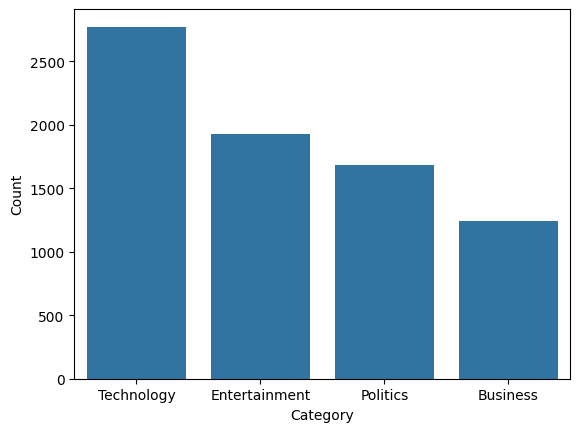

In [35]:
count = train.Category.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Category')
plt.ylabel('Count')

In [36]:
train['Text_length'] = train['STORY'].apply(len)
train.head(5)

,STORY,SECTION,Category,Text_length
0,But the most painful was the huge reversal in ...,3,Business,843
1,How formidable is the opposition alliance amon...,0,Politics,129
2,Most Asian currencies were trading lower today...,3,Business,386
3,"If you want to answer any question, click on ...",1,Technology,587
4,"In global markets, gold prices edged up today ...",3,Business,299


**Text length for each category**

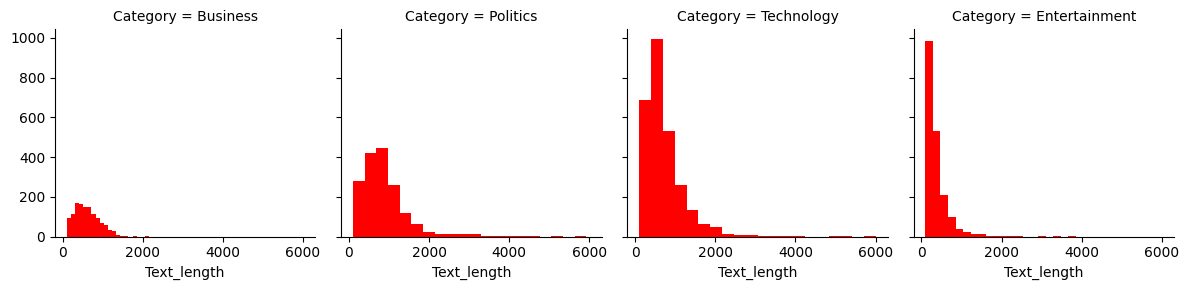

In [37]:
#une grille de graphe
len_text = sns.FacetGrid(data=train, col='Category')
len_text.map(plt.hist, 'Text_length', bins=20, color='r')

In [38]:
def plot_(a):
    x1 = train[train.SECTION == 0][a]
    x2 = train[train.SECTION == 1][a]
    x3 = train[train.SECTION == 2][a]
    x4 = train[train.SECTION == 3][a]
    plt.subplot(1,1,1)
    _ = plt.hist(x1, alpha=0.8, color="red", bins=50)
    __= plt.hist(x2, alpha=0.5, color="grey", bins=50)
    ___ = plt.hist(x3, alpha=0.8, color="green", bins=50)
    ____= plt.hist(x4, alpha=0.5, color="black", bins=50)
    return ____

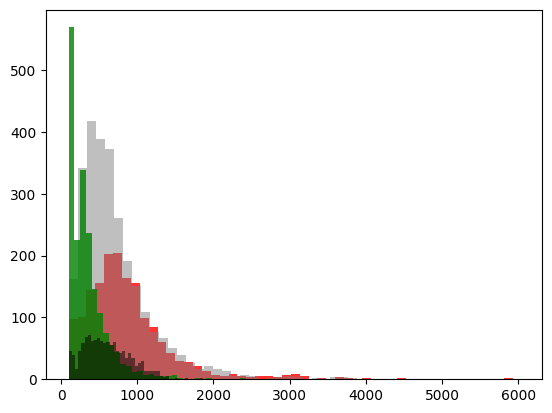

In [39]:

plt_len_text = plot_('Text_length')


In [40]:
train['words_counts']=train.STORY.str.split().map(lambda x: len(x))
train.head()

,STORY,SECTION,Category,Text_length,words_counts
0,But the most painful was the huge reversal in ...,3,Business,843,148
1,How formidable is the opposition alliance amon...,0,Politics,129,17
2,Most Asian currencies were trading lower today...,3,Business,386,58
3,"If you want to answer any question, click on ...",1,Technology,587,103
4,"In global markets, gold prices edged up today ...",3,Business,299,46


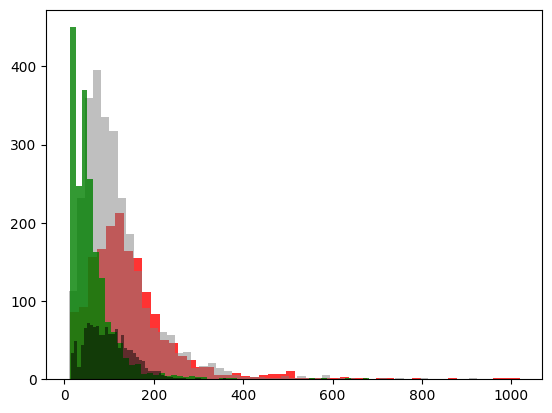

In [41]:
plot_words_counts = plot_("words_counts")

In [42]:
#punctuation count
import string
train['punctuation_count'] = train['STORY'].map(lambda x: len
 ([c for c in str(x) if c in string.punctuation]))
train.head()

,STORY,SECTION,Category,Text_length,words_counts,punctuation_count
0,But the most painful was the huge reversal in ...,3,Business,843,148,12
1,How formidable is the opposition alliance amon...,0,Politics,129,17,6
2,Most Asian currencies were trading lower today...,3,Business,386,58,31
3,"If you want to answer any question, click on ...",1,Technology,587,103,12
4,"In global markets, gold prices edged up today ...",3,Business,299,46,10


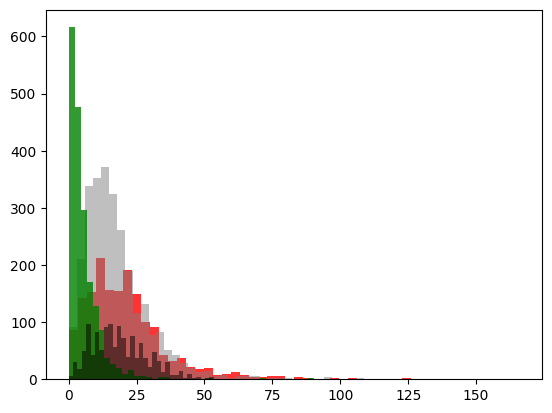

In [43]:
_ =plot_('punctuation_count')

In [44]:
# Initialize the stemmer
stemmer = PorterStemmer()
def clean_text(text):
    text = text.lower()        # lower-case all characters
    text =  re.sub(r'@\S+', '',text)     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)      # remove urls
    text =  re.sub(r'pic.\S+', '',text)
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)        # only keeps characters and '
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')     # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
        # Apply stemming and remove stopwords
    text = " ".join([stemmer.stem(i) for i in words if i not in stopwords and len(i) > 2])
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()        # remove repeated spaces in the beginin and end of the text
    return text


In [45]:
train['Text_cleaning'] = train.STORY.apply(clean_text)


In [46]:
train['len_text_clean']=train.Text_cleaning.apply(len)
train.head()

,STORY,SECTION,Category,Text_length,words_counts,punctuation_count,Text_cleaning,len_text_clean
0,But the most painful was the huge reversal in ...,3,Business,843,148,12,painful huge reversal fee income unheard among...,573
1,How formidable is the opposition alliance amon...,0,Politics,129,17,6,formidable opposition alliance among congress ...,108
2,Most Asian currencies were trading lower today...,3,Business,386,58,31,asian currencies trading lower today south kor...,230
3,"If you want to answer any question, click on ...",1,Technology,587,103,12,want answer question click answer clicking ans...,360
4,"In global markets, gold prices edged up today ...",3,Business,299,46,10,global markets gold prices edged today disappo...,247


In [47]:
train.to_csv("/content/train_clean.csv", index=False)

In [48]:
vectorizer = CountVectorizer()
data_vectorizer = vectorizer.fit_transform(train['Text_cleaning'])

In [49]:
joblib.dump(vectorizer, '/content/vectorizer.joblib')

['/content/vectorizer.joblib']

In [50]:
label = train['SECTION']

In [51]:
my_Category =['Politics','Technology','Entertainment','Business']

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_vectorizer, label, test_size=0.2, random_state=42)

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_vectorizer, label, test_size=0.2, random_state=42)

In [54]:
def model(name_model):
    # Création et entraînement du modèle
    a = name_model()
    a.fit(X_train, y_train)
    y_pred = a.predict(X_test)

    # Évaluation du modèle
    Acc_train = a.score(X_train, y_train)
    acc_test = a.score(X_test, y_test)
    print('Train Accuracy : {:.2f}%'.format(Acc_train * 100))
    print('Test Accuracy  : {:.2f}%'.format(acc_test * 100))
    print('******** Classification Report ***************')
    print(classification_report(y_test, y_pred, target_names=my_Category))
    print('******** Predicting the Test set results ******')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)

    # Enregistrement du modèle avec un nom unique
    model_name = type(a).__name__  # Utilise le nom de la classe comme nom du fichier
    file_path = f'/content/{model_name}.joblib'
    joblib.dump(a, file_path)
    print(f"Modèle enregistré sous le nom : {file_path}")

    return acc_test

**logistics regression**

Train Accuracy : 99.77%
Test Accuracy  : 95.74%
******** Classification Report ***************
               precision    recall  f1-score   support

     Politics       0.98      0.92      0.95       323
   Technology       0.98      0.96      0.97       549
Entertainment       0.92      0.99      0.95       402
     Business       0.94      0.96      0.95       252

     accuracy                           0.96      1526
    macro avg       0.96      0.96      0.95      1526
 weighted avg       0.96      0.96      0.96      1526

******** Predicting the Test set results ******
Modèle enregistré sous le nom : /content/LogisticRegression.joblib


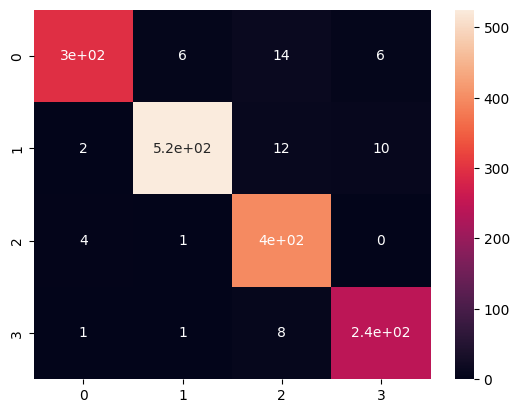

In [55]:
from sklearn.linear_model import LogisticRegression
acc_LR = model(LogisticRegression)

Train Accuracy : 97.90%
Test Accuracy  : 93.51%
******** Classification Report ***************
               precision    recall  f1-score   support

     Politics       0.97      0.85      0.90       323
   Technology       0.93      0.97      0.95       549
Entertainment       0.90      0.97      0.93       402
     Business       0.98      0.93      0.95       252

     accuracy                           0.94      1526
    macro avg       0.94      0.93      0.93      1526
 weighted avg       0.94      0.94      0.93      1526

******** Predicting the Test set results ******
Modèle enregistré sous le nom : /content/SVC.joblib


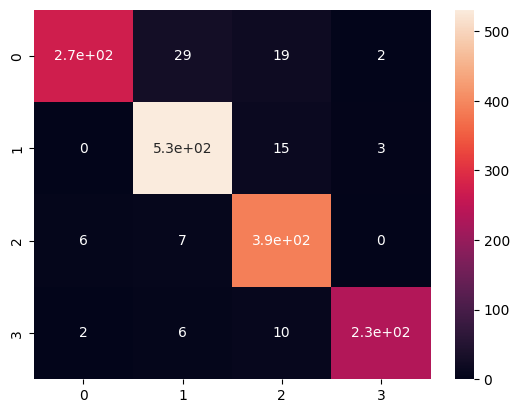

In [56]:
from sklearn.svm import SVC
acc_SVC = model(SVC)

Train Accuracy : 99.77%
Test Accuracy  : 87.48%
******** Classification Report ***************
               precision    recall  f1-score   support

     Politics       0.90      0.88      0.89       323
   Technology       0.88      0.86      0.87       549
Entertainment       0.88      0.90      0.89       402
     Business       0.82      0.85      0.83       252

     accuracy                           0.87      1526
    macro avg       0.87      0.87      0.87      1526
 weighted avg       0.88      0.87      0.87      1526

******** Predicting the Test set results ******
Modèle enregistré sous le nom : /content/DecisionTreeClassifier.joblib


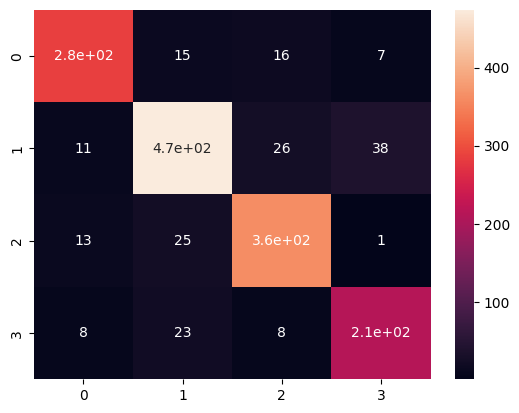

In [57]:
from sklearn.tree import DecisionTreeClassifier
acc_DTC = model(DecisionTreeClassifier)

Train Accuracy : 98.07%
Test Accuracy  : 97.05%
******** Classification Report ***************
               precision    recall  f1-score   support

     Politics       0.96      0.97      0.96       323
   Technology       0.98      0.97      0.97       549
Entertainment       0.98      0.97      0.97       402
     Business       0.95      0.99      0.97       252

     accuracy                           0.97      1526
    macro avg       0.97      0.97      0.97      1526
 weighted avg       0.97      0.97      0.97      1526

******** Predicting the Test set results ******
Modèle enregistré sous le nom : /content/MultinomialNB.joblib


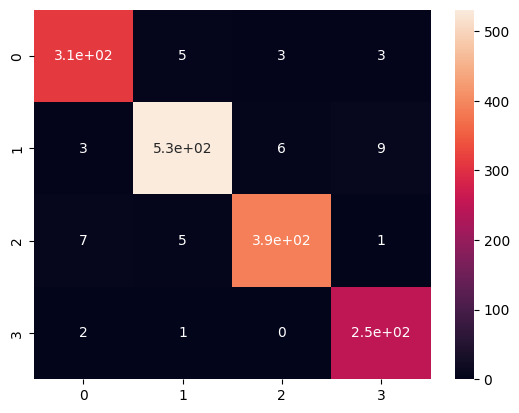

In [58]:
from sklearn.naive_bayes import MultinomialNB
acc_MNB = model(MultinomialNB)

Train Accuracy : 99.77%
Test Accuracy  : 95.28%
******** Classification Report ***************
               precision    recall  f1-score   support

     Politics       0.95      0.94      0.94       323
   Technology       0.96      0.96      0.96       549
Entertainment       0.95      0.97      0.96       402
     Business       0.95      0.93      0.94       252

     accuracy                           0.95      1526
    macro avg       0.95      0.95      0.95      1526
 weighted avg       0.95      0.95      0.95      1526

******** Predicting the Test set results ******
Modèle enregistré sous le nom : /content/RandomForestClassifier.joblib


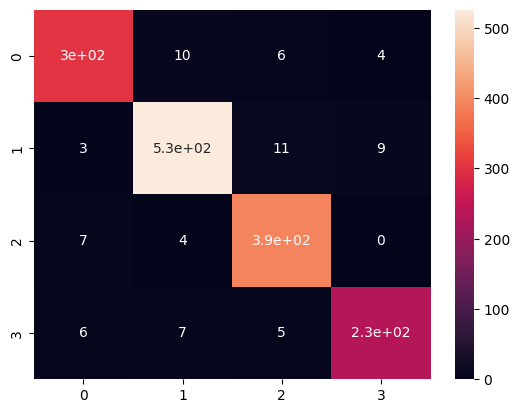

In [59]:
from sklearn.ensemble import RandomForestClassifier
acc_RFC = model(RandomForestClassifier)

Train Accuracy : 76.76%
Test Accuracy  : 67.50%
******** Classification Report ***************
               precision    recall  f1-score   support

     Politics       0.96      0.65      0.78       323
   Technology       0.95      0.58      0.72       549
Entertainment       0.47      1.00      0.64       402
     Business       0.89      0.41      0.56       252

     accuracy                           0.67      1526
    macro avg       0.82      0.66      0.67      1526
 weighted avg       0.81      0.67      0.68      1526

******** Predicting the Test set results ******
Modèle enregistré sous le nom : /content/KNeighborsClassifier.joblib


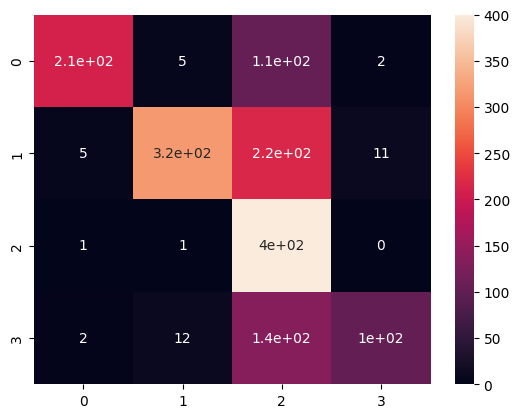

In [60]:
from sklearn.neighbors import KNeighborsClassifier
acc_KNC = model(KNeighborsClassifier)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Accuracy : 87.66%
Test Accuracy  : 86.70%
******** Classification Report ***************
               precision    recall  f1-score   support

     Politics       0.91      0.86      0.89       323
   Technology       0.92      0.82      0.87       549
Entertainment       0.78      0.94      0.85       402
     Business       0.88      0.85      0.87       252

     accuracy                           0.87      1526
    macro avg       0.87      0.87      0.87      1526
 weighted avg       0.87      0.87      0.87      1526

******** Predicting the Test set results ******
Modèle enregistré sous le nom : /content/AdaBoostClassifier.joblib


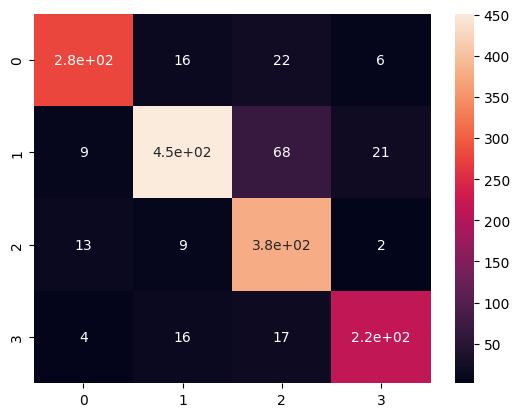

In [61]:
from sklearn.ensemble import AdaBoostClassifier
acc_ABC = model(AdaBoostClassifier)

In [62]:
output = pd.DataFrame({"Model":['Logistic Regression','SVC','Decision Tree Classifier',
                                'MultinomialNB','Random Forest Classifier',
                               'KNeighborsClassifier','AdaBoost Classifier',],
                      "Accuracy":[acc_LR, acc_SVC, acc_DTC, acc_MNB, acc_RFC, acc_KNC, acc_ABC]})

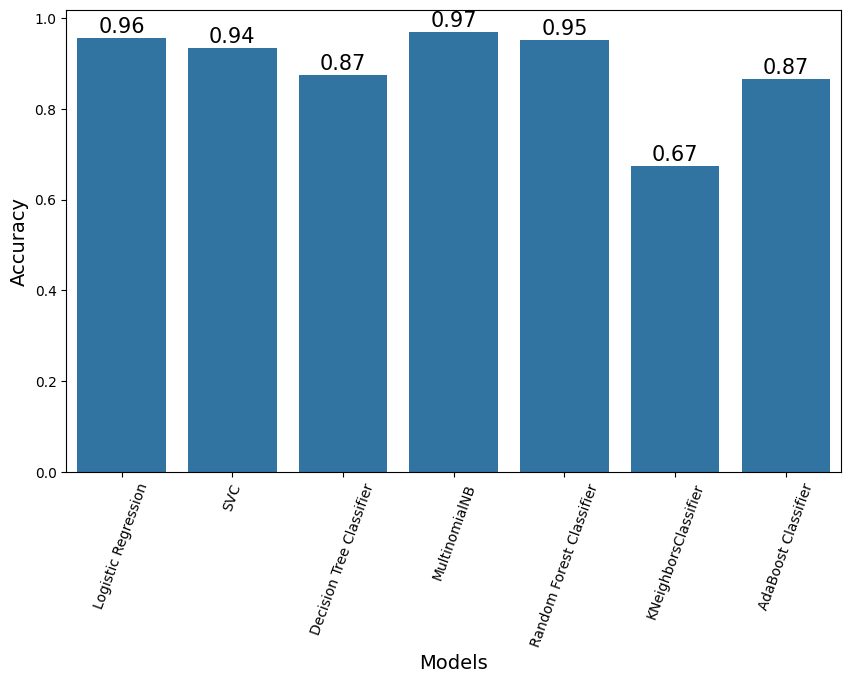

In [63]:

plt.figure(figsize=(10, 6))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=70);
plt.ylabel("Accuracy", size=14)
plt.show()

In [64]:
test.head(5)

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...
2,It can be confusing to pick the right smartpho...
3,The mobile application is integrated with a da...
4,We have rounded up some of the gadgets that sh...


In [65]:
test['Text_cleaning'] = test.STORY.apply(clean_text)


In [66]:
test.head(5)

,STORY,Text_cleaning
0,2019 will see gadgets like gaming smartphones ...,see gadgets like gaming smartphones wearable m...
1,It has also unleashed a wave of changes in the...,also unleashed wave changes mcu make sure futu...
2,It can be confusing to pick the right smartpho...,confusing pick right smartphone segregated top...
3,The mobile application is integrated with a da...,mobile application integrated dashboard confir...
4,We have rounded up some of the gadgets that sh...,rounded gadgets showed left indelible mark con...


In [69]:
model_path = '/content/MultinomialNB.joblib'
vectorizer_path = '/content/vectorizer.joblib'

# Charger le modèle et le vectorizer enregistrés
loaded_model = joblib.load(model_path)
loaded_vectorizer = joblib.load(vectorizer_path)

# Vectoriser les données de `test['Text_cleaning']`
new_data_vectorized = loaded_vectorizer.transform(test['Text_cleaning'])

# Faire des prédictions
predictions = loaded_model.predict(new_data_vectorized)

# Ajouter les prédictions dans une nouvelle colonne `SECTION`
test['SECTION'] = predictions

# Afficher les résultats
print(test[['Text_cleaning', 'SECTION']].head())

                                       Text_cleaning  SECTION
0  see gadgets like gaming smartphones wearable m...        1
1  also unleashed wave changes mcu make sure futu...        2
2  confusing pick right smartphone segregated top...        1
3  mobile application integrated dashboard confir...        0
4  rounded gadgets showed left indelible mark con...        1


In [70]:
test["Category"] = test["SECTION"]
rem = {"Category": {0: "Politics", 1: "Technology", 2:"Entertainment", 3:"Business"}}
test = test.replace(rem)
print(test[['Text_cleaning', 'Category']].head())

                                       Text_cleaning       Category
0  see gadgets like gaming smartphones wearable m...     Technology
1  also unleashed wave changes mcu make sure futu...  Entertainment
2  confusing pick right smartphone segregated top...     Technology
3  mobile application integrated dashboard confir...       Politics
4  rounded gadgets showed left indelible mark con...     Technology
